In [2]:
import math

In [3]:
import pipe_pytools.polar_plot as pp
import pipe_pytools.tools as tl
import pipe_pytools.grid as gr

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
cf,Xmax,epsr,lx,Jm,lt,nsym,VEL = tl.get_bcp("xmean.bcp")

In [6]:
cf

0.78

In [7]:
t,dt,Dp,Re,Xmax,epsr,lx,Jm,lt,nsym,vel = tl.get_scp("lin0.scp")

In [8]:
vel_tmp = vel
vel = np.zeros_like(vel)

vel.T[1:16] = vel_tmp.T[-16:-1]
vel.T[16:-1] = vel_tmp.T[1:-16]

del vel_tmp

In [9]:
vel /= (vel.max() * 21)

In [10]:
x = gr.X(2**lx, Xmax)
r = gr.R(Jm, epsr)
th = gr.Th(2**lt, nsym)

In [11]:
Im = x.m
hx = x.h
yt = r.f
yt1 = r.f1
rt = r.n
rt1 = r.n1
Km = th.m
ht = th.h

In [12]:
def bc(vel):
    u,v,w = vel
        
    vel[:,:,:,0] = vel[:,:,:,-2]
    vel[:,:,:,-1] = vel[:,:,:,1]
    
    for i in range(0,Im+1):
        for j in range(1,Jm+1):
            u.T[i,j,0] = u.T[i,j,1]
            u.T[i,j,Km+1] = u.T[i,j,Km]
            
        for k in range(1,Km+1):
            u.T[i,Jm+1,k] = - u.T[i,Jm,k]
            
    for k in range(1,Km+1):
        for i in range(1,Im+1):
            v.T[i,Jm,k] = 0.0
            
    for j in range(1,Jm+1):
        for i in range(1,Im+1):
            v.T[i,j,0] = v.T[i,j,1]
            v.T[i,j,Km+1] = v.T[i,j,Km]
            
    for j in range(1,Jm+1):
        for i in range(0,Im+2):
            w.T[i,j,0] = 0.0
            w.T[i,j,Km] = 0.0
            
    for k in range(0,Km+1):
        for i in range(1,Im+1):
            w.T[i,Jm+1,k] = - w.T[i,Jm,k] * yt[Jm] / yt[Jm+1]
            
    return vel

In [13]:
def rot(vel):
    bc(vel)
    u,v,w = vel
    
    om = np.zeros((3,Km+2,Jm+2,Im+2))
    ox,on,ot = om
    
    for i in range(1,Im+1):
        for j in range(1,Jm+1):
            for k in range(0,Km+1):
                w0 = w.T[i,j,k]
                w1 = w.T[i,j+1,k]
                v0 = v.T[i,j,k]
                v1 = v.T[i,j,k+1]
                ox.T[i,j,k] = ((yt[j+1]*w1 - yt[j]*w0) / rt1[j] - (v1 - v0) / ht) / rt[j]
                
        for j in range(0,1):
            for k in range(0,Km+1):
                ox.T[i,j,k] = 0.0
                
    for k in range(0,Km+1):
        for j in range(1,Jm+1):
            for i in range(0,Im+1):
                u0 = u.T[i,j,k]
                u1 = u.T[i,j,k+1]
                w0 = w.T[i,j,k]
                w1 = w.T[i+1,j,k]
                on.T[i,j,k] = (u1 - u0) / (yt[j] * ht) - (w1 - w0) / hx
                
    for k in range(1,Km+1):
        for j in range(1,Jm+1):
            for i in range(0,Im+1):
                u0 = u.T[i,j,k]
                u1 = u.T[i,j+1,k]
                v0 = v.T[i,j,k]
                v1 = v.T[i+1,j,k]
                ot.T[i,j,k] = (v1 - v0) / hx - (u1 - u0) / rt1[j]
    
    return om

In [14]:
def nonlin(vel,om):
    u,v,w = vel
    ox,on,ot = om
    velt = np.zeros((3,Km+2,Jm+2,Im+2))
    ut,vt,wt = velt
    
    for i in range(1,Im+1):
        for j in range(1,Jm+1):
            for k in range(1,Km+1):
                v0 = 0.5 * (v.T[i,j-1,k] + v.T[i+1,j-1,k])
                v1 = 0.5 * (v.T[i,j,k] + v.T[i+1,j,k])
                ot0 = rt[j-1] * rt1[j-1] * ot.T[i,j-1,k]
                ot1 = rt[j] * rt1[j] * ot.T[i,j,k]
                w0 = 0.5 * (w.T[i,j,k-1] + w.T[i+1,j,k-1])
                w1 = 0.5 * (w.T[i,j,k] + w.T[i+1,j,k])
                or0 = on.T[i,j,k-1]
                or1 = on.T[i,j,k]
                ut.T[i,j,k] = 0.5 * ((v0*ot0 + v1*ot1) / (yt[j] * yt1[j]) - (w0*or0 + w1*or1))
        
    for k in range(1,Km+1):
        for i in range(1,Im+1):
            for j in range(1,Jm):
                w0 = 0.5 * (w.T[i,j,k-1] + w.T[i,j+1,k-1])
                w1 = 0.5 * (w.T[i,j,k] + w.T[i,j+1,k])
                ox0 = ox.T[i,j,k-1]
                ox1 = ox.T[i,j,k]
                u0 = 0.5 * (u.T[i-1,j,k] + u.T[i-1,j+1,k])
                u1 = 0.5 * (u.T[i,j,k] + u.T[i,j+1,k])
                ot0 = ot.T[i-1,j,k]
                ot1 = ot.T[i,j,k]
                vt.T[i,j,k] = 0.5 * ((w0*ox0 + w1*ox1) - (u0*ot0 + u1*ot1))
        
            vt.T[i,Jm,k] = 0.0
            
    for k in range(1,Km+1):
        for j in range(1,Jm+1):
            for i in range(1,Im+1):
                u0 = 0.5 * (u.T[i-1,j,k] + u.T[i-1,j,k+1])
                u1 = 0.5 * (u.T[i,j,k] + u.T[i,j,k+1])
                or0 = on.T[i-1,j,k]
                or1 = on.T[i,j,k]
                v0 = 0.5 * (v.T[i,j-1,k] + v.T[i,j-1,k+1])
                v1 = 0.5 * (v.T[i,j,k] + v.T[i,j,k+1])
                ox0 = rt[j-1] * rt1[j-1] * ox.T[i,j-1,k]
                ox1 = rt[j] * rt1[j] * ox.T[i,j,k]
                wt.T[i,j,k] = 0.5 * ((u0*or0 + u1*or1) - (v0*ox0 + v1*ox1) / (yt[j] * yt1[j]))
                
    return velt

In [15]:
def viscous(om,Re):
    ox,on,ot = om
    
    velt = np.zeros((3,Km+2,Jm+2,Im+2))
    ut,vt,wt = velt
    
    for i in range(1,Im+1):
        for j in range(1,Jm+1):
            for k in range(1,Km+1):
                ot0 = ot.T[i,j-1,k]
                ot1 = ot.T[i,j,k]
                or0 = on.T[i,j,k-1]
                or1 = on.T[i,j,k]
                ut.T[i,j,k] = - ((rt[j]*ot1 - rt[j-1]*ot0) / yt1[j] - (or1 - or0) / ht) / yt[j] / Re
        
    for k in range(1,Km+1):
        for j in range(1,Jm):
            for i in range(1,Im+1):
                ox0 = ox.T[i,j,k-1]
                ox1 = ox.T[i,j,k]
                ot0 = ot.T[i-1,j,k]
                ot1 = ot.T[i,j,k]
                vt.T[i,j,k] = - ((ox1 - ox0) / (rt[j] * ht) - (ot1 - ot0) / hx) / Re
        
    for k in range(1,Km+1):
        for j in range(1,Jm+1):
            for i in range(1,Im+1):
                ox0 = ox.T[i,j-1,k]
                ox1 = ox.T[i,j,k]
                or0 = on.T[i-1,j,k]
                or1 = on.T[i,j,k]
                wt.T[i,j,k] = - ((or1 - or0) / hx - (ox1 - ox0) / yt1[j]) / Re
        
    return velt

In [16]:
om = rot(vel)

In [17]:
OM = rot(VEL)

In [18]:
s = rot(nonlin(VEL,om) + nonlin(vel,OM) + viscous(om,Re))

In [19]:
om.T[0] = om.T[-2]
om.T[-1] = om.T[1]

In [20]:
for i in range(1,Im+1):
    s.T[i] += cf*(om.T[i+1] - om.T[i-1]) / (2*hx)

/home/user/miniconda/lib/python2.7/site-packages/matplotlib/tri/triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)
/home/user/miniconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


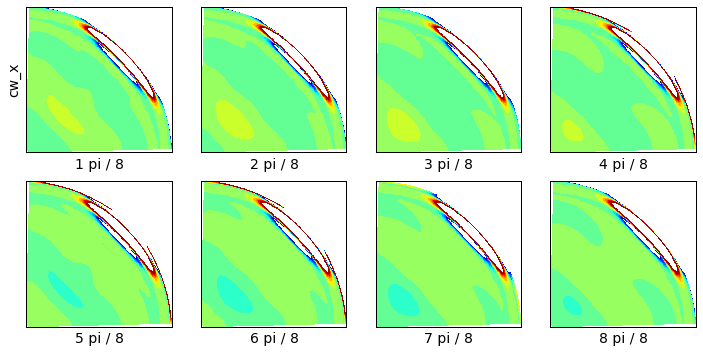

In [21]:
plt.figure(figsize=(12,12))
n=1
ff = True

for ii in range(1,65,8):
    plt.subplot(4,4,n)
    if ff:
        ff = False
        plt.ylabel("cw_x", fontsize=14)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], (s)[0,1:-1,1:-1,ii], (-0.006,0.006))
    #pp.polar_arrow(vel[1,1:-1:4,1:-1:4,ii], vel[2,1:-1:4,1:-1:4,ii], r.f[1:-1:4], th.f[1:-1:4],3000)
    #pp.polar_contour(yt[1:-1], th.f[1:-1], ox[1:-1,1:-1,ii], -0.16, +0.16, 11)
    plt.xlabel("%d pi / 8" % n, fontsize=14)
    n+=1

In [22]:
u,v,w = vel
ox,on,ot = om

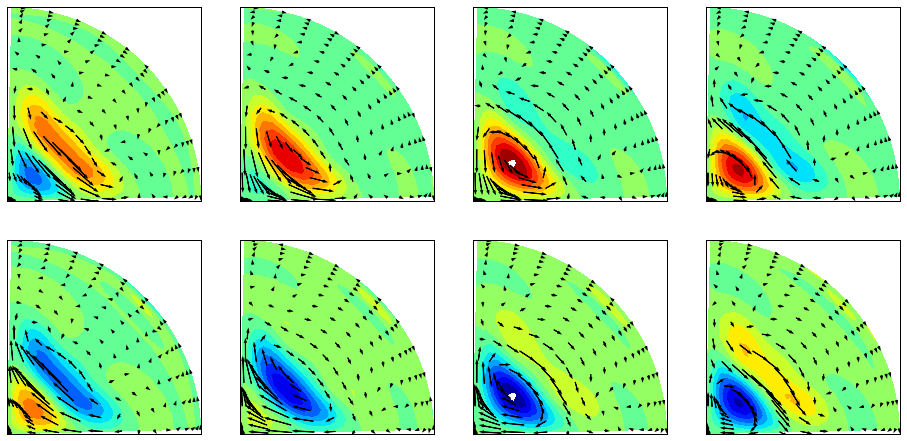

In [23]:
plt.figure(figsize=(16,16))
n=1
for ii in range(1,65,8):
    plt.subplot(4,4,n)
    n+=1
    pp.polar_contourf(yt[1:-1], th.f[1:-1], ox[1:-1,1:-1,ii], (-0.16,0.16))
    pp.polar_arrow(v[1:-1:3,1:-1:3,ii], w[1:-1:3,1:-1:3,ii], r.f[1:-1:3], th.f[1:-1:3],10)

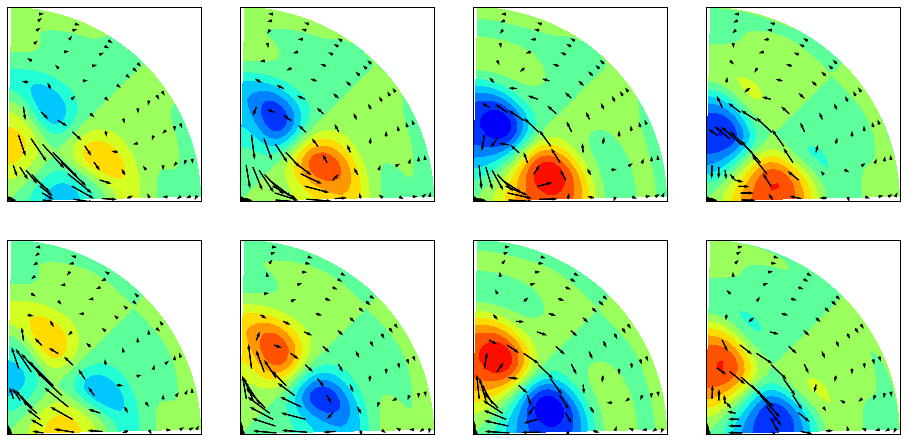

In [24]:
plt.figure(figsize=(16,16))
n=1
for ii in range(1,65,8):
    plt.subplot(4,4,n)
    n+=1
    pp.polar_contourf(yt[1:-1], th.f[1:-1], u[1:-1,1:-1,ii], (-0.05,0.05))
    pp.polar_arrow(v[1:-1:4,1:-1:4,ii], w[1:-1:4,1:-1:4,ii], r.f[1:-1:4], th.f[1:-1:4],10)

In [42]:
def vmap(v,vname):
    vmax = max(v.max(), -v.min())
    plt.figure(figsize=(12,12))
    n=1
    for ii in range(1,65,8):
        plt.subplot(4,4,n)
        plt.xlabel("%d pi / 4" % n, fontsize=14)
        if n == 1:
            plt.ylabel("%s, max=%5.3f" % (vname, vmax), fontsize=14)
        pp.polar_contourf(yt[1:-1], th.f[1:-1], v[1:-1,1:-1,ii], (-vmax,vmax))
        n+=1

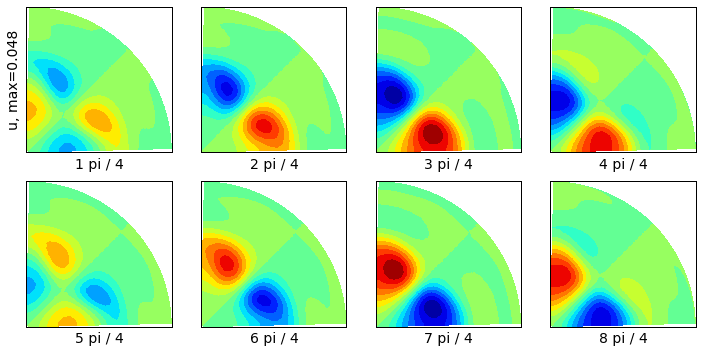

In [43]:
vmap(u,"u")

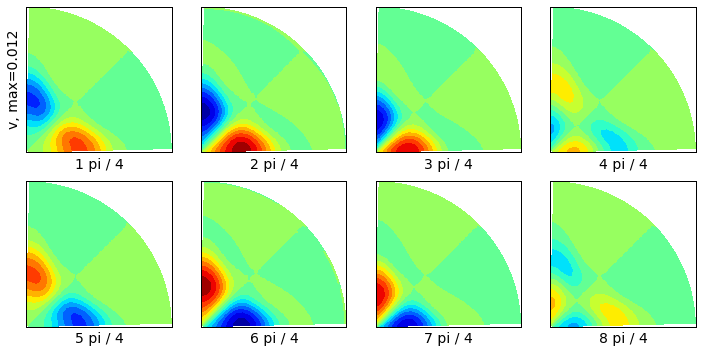

In [44]:
vmap(v,"v")

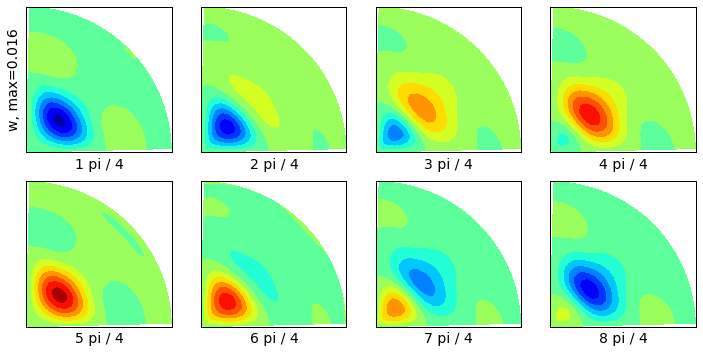

In [45]:
vmap(w,"w")

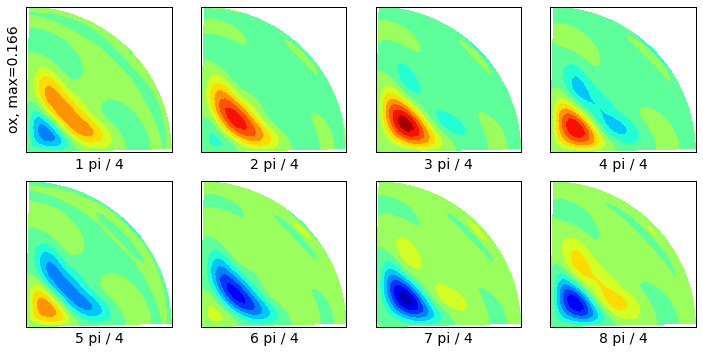

In [46]:
vmap(ox,"ox")

In [24]:
oxt = np.zeros_like(ox)

for k in range(1,Km+1):
    for j in range(1,Jm+1):
        for i in range(1,Im+1):
            oxt[k,j,i] = (ox[k+1,j,i] - ox[k,j,i]) / (rt[j] * ht)

In [25]:
cwx = - w*oxt

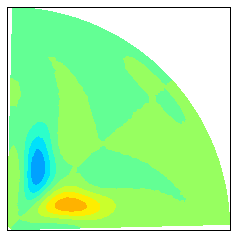

In [26]:
pp.polar_contourf(yt[1:-1], th.f[1:-1], cwx[1:-1,1:-1,1:-1].mean(-1), (-0.006,0.006))

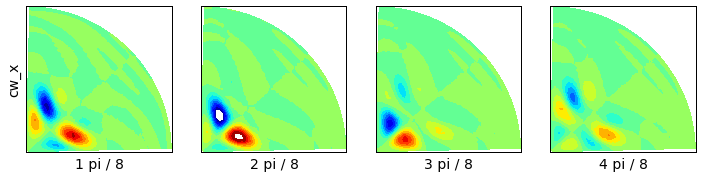

In [27]:
plt.figure(figsize=(12,12))
n=1
ff = True

for ii in range(1,32,8):
    plt.subplot(4,4,n)
    if ff:
        ff = False
        plt.ylabel("cw_x", fontsize=14)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], cwx[1:-1,1:-1,ii], (-0.006,0.006))
    #pp.polar_arrow(vel[1,1:-1:4,1:-1:4,ii], vel[2,1:-1:4,1:-1:4,ii], r.f[1:-1:4], th.f[1:-1:4],3000)
    #pp.polar_contour(yt[1:-1], th.f[1:-1], ox[1:-1,1:-1,ii], -0.16, +0.16, 11)
    plt.xlabel("%d pi / 8" % n, fontsize=14)
    n+=1

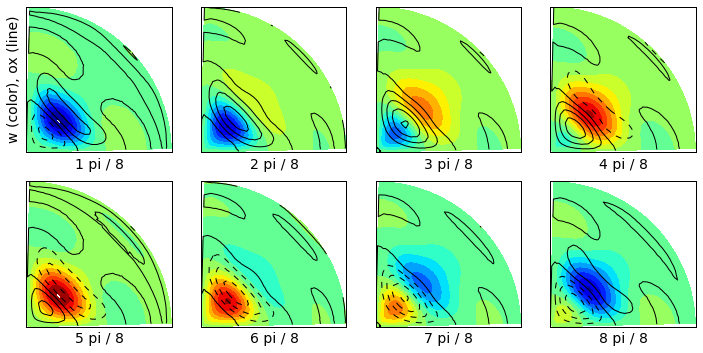

In [32]:
plt.figure(figsize=(12,12))
n=1
ff=True
for ii in range(1,65,8):
    plt.subplot(4,4,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], w[1:-1,1:-1,ii], (-0.016,0.016))
    #pp.polar_arrow(vel[1,1:-1:4,1:-1:4,ii], vel[2,1:-1:4,1:-1:4,ii], r.f[1:-1:4], th.f[1:-1:4],3000)
    pp.polar_contour(yt[1:-1], th.f[1:-1], ox[1:-1,1:-1,ii], -0.16, +0.16, 11)
    plt.xlabel("%d pi / 8" % n, fontsize=14)
    n+=1
    if ff:
        ff=False
        plt.ylabel("w (color), ox (line)", fontsize=14)

In [52]:
def get_ox_part(vel):
    bc(vel)
    u,v,w = vel
    
    ox_v = np.zeros((Km+2,Jm+2,Im+2))
    ox_w = np.zeros((Km+2,Jm+2,Im+2))
    
    for i in range(1,Im+1):
        for j in range(1,Jm+1):
            for k in range(0,Km+1):
                w0 = w.T[i,j,k]
                w1 = w.T[i,j+1,k]
                v0 = v.T[i,j,k]
                v1 = v.T[i,j,k+1]
                ox_v.T[i,j,k] =  - (v1 - v0) / (ht * rt[j])
                ox_w.T[i,j,k] = (yt[j+1]*w1 - yt[j]*w0) / (rt1[j] * rt[j])
                
        for j in range(0,1):
            for k in range(0,Km+1):
                ox_v.T[i,j,k] = 0.0
                ox_w.T[i,j,k] = 0.0
        
    return ox_v, ox_w

In [53]:
ox_v, ox_w = get_ox_part(vel)

In [54]:
ox1max = ox.max()

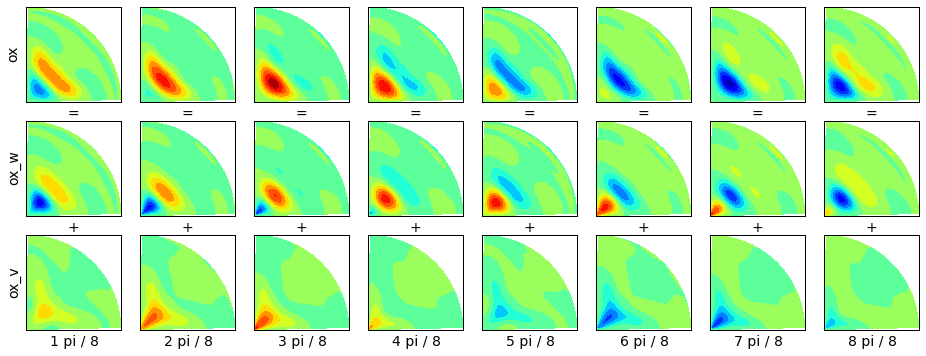

In [75]:
plt.figure(figsize=(16,16))
n=1
ff = True

for ii in range(1,65,8):
    
    plt.subplot(8,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], ox[1:-1,1:-1,ii], (-ox1max, ox1max))
    #pp.polar_arrow(vel[1,1:-1:3,1:-1:3,ii], lin[2,1:-1:3,1:-1:3,ii], r.f[1:-1:3], th.f[1:-1:3],2000)
    if ff:
        plt.ylabel("ox",fontsize=14)
    plt.xlabel("=", fontsize=14)
    
    plt.subplot(8,8,n+8)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], ox_w[1:-1,1:-1,ii], (-ox1max, ox1max))
    #pp.polar_arrow(vel[1,1:-1:3,1:-1:3,ii], lin[2,1:-1:3,1:-1:3,ii], r.f[1:-1:3], th.f[1:-1:3],2000)
    if ff:
        plt.ylabel("ox_w",fontsize=14)
    plt.xlabel("+", fontsize=14)
    
    plt.subplot(8,8,n+16)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], ox_v[1:-1,1:-1,ii], (-ox1max, ox1max))
    #pp.polar_arrow(vel[1,1:-1:3,1:-1:3,ii], vel1[2,1:-1:3,1:-1:3,ii], r.f[1:-1:3], th.f[1:-1:3],2000)
    if ff:
        plt.ylabel("ox_v",fontsize=14)
        ff = False
    plt.xlabel("%d pi / 8" % n, fontsize=14)
    n += 1

In [56]:
def get_div_part(vel):
    u,v,w = vel
    
    div = np.zeros((3,Km+2,Jm+2,Im+2))
    div_u, div_v, div_w = div
    
    for k in range(1,Km+1):
        for j in range(1,Jm+1):
            for i in range(1,Im+2):
                div_u.T[i,j,k] = (u.T[i,j,k] - u.T[i-1,j,k]) / hx
                div_v.T[i,j,k] = (rt[j] * v.T[i,j,k] - rt[j-1] * v.T[i,j-1,k]) / (yt[j] * yt1[j])
                div_w.T[i,j,k] = (w.T[i,j,k] - w.T[i,j,k-1]) / (yt[j] * ht)
                                                    
    return div

In [57]:
divx, divr, divt = get_div_part(vel)

In [58]:
dmax = max(divx.max(), divr.max(), divt.max())

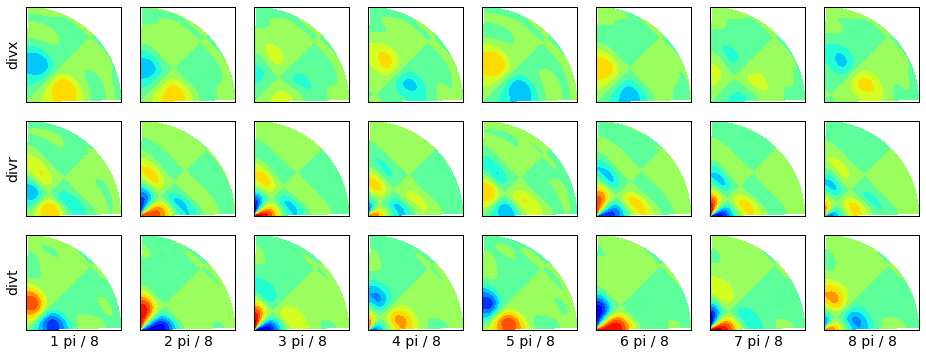

In [60]:
plt.figure(figsize=(16,16))
n=1
ff = True

for ii in range(1,65,8):
    
    plt.subplot(8,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], divx[1:-1,1:-1,ii], (-dmax, dmax))
    #pp.polar_arrow(vel[1,1:-1:3,1:-1:3,ii], lin[2,1:-1:3,1:-1:3,ii], r.f[1:-1:3], th.f[1:-1:3],2000)
    if ff:
        plt.ylabel("divx",fontsize=14)
    
    plt.subplot(8,8,n+8)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], divr[1:-1,1:-1,ii], (-dmax, dmax))
    #pp.polar_arrow(vel[1,1:-1:3,1:-1:3,ii], vel1[2,1:-1:3,1:-1:3,ii], r.f[1:-1:3], th.f[1:-1:3],2000)
    if ff:
        plt.ylabel("divr",fontsize=14)
    
    plt.subplot(8,8,n+16)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], divt[1:-1,1:-1,ii], (-dmax, dmax))
    #pp.polar_arrow(vel[1,1:-1:3,1:-1:3,ii], vel1[2,1:-1:3,1:-1:3,ii], r.f[1:-1:3], th.f[1:-1:3],2000)
    if ff:
        plt.ylabel("divt",fontsize=14)
        ff = False
    plt.xlabel("%d pi / 8" % n, fontsize=14)
    
    n += 1

w первостепенное значение, толкает как u , так и v

In [53]:
umax = u.max()
vmax = v.max()
wmax = w.max()
oxmax  = ox.max()

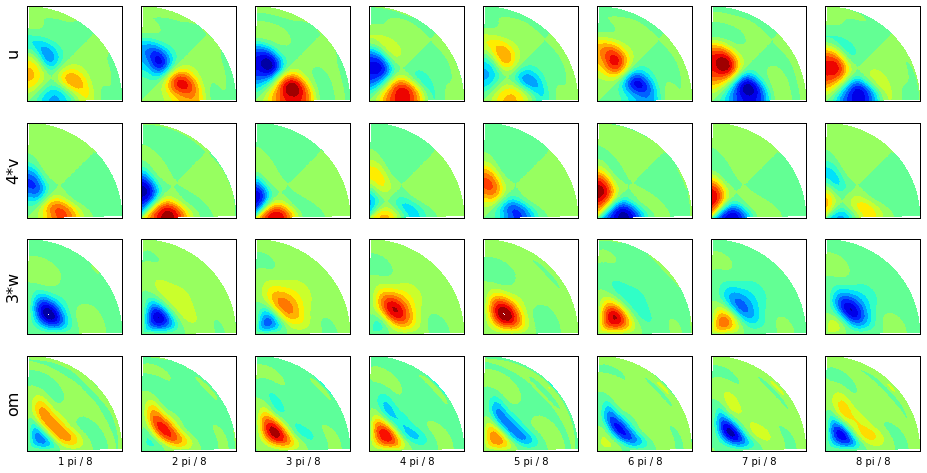

In [58]:
plt.figure(figsize=(16,8))
n=1
ff = True

for ii in range(1,65,8):
    
    plt.subplot(4,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], u[1:-1,1:-1,ii], (-umax, umax))
    #pp.polar_arrow(vel[1,1:-1:3,1:-1:3,ii], lin[2,1:-1:3,1:-1:3,ii], r.f[1:-1:3], th.f[1:-1:3],2000)
    if ff:
        plt.ylabel("u",fontsize=16)
    
    plt.subplot(4,8,n+8)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], v[1:-1,1:-1,ii], (-umax/4, umax/4))
    #pp.polar_arrow(vel[1,1:-1:3,1:-1:3,ii], lin[2,1:-1:3,1:-1:3,ii], r.f[1:-1:3], th.f[1:-1:3],2000)
    if ff:
        plt.ylabel("4*v",fontsize=16)
    
    plt.subplot(4,8,n+16)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], w[1:-1,1:-1,ii], (-umax/3, umax/3))
    #pp.polar_arrow(vel[1,1:-1:3,1:-1:3,ii], lin[2,1:-1:3,1:-1:3,ii], r.f[1:-1:3], th.f[1:-1:3],2000)
    if ff:
        plt.ylabel("3*w",fontsize=16)
    
    plt.subplot(4,8,n+24)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], om[0,1:-1,1:-1,ii], (-oxmax, oxmax))
    #pp.polar_arrow(vel[1,1:-1:3,1:-1:3,ii], vel1[2,1:-1:3,1:-1:3,ii], r.f[1:-1:3], th.f[1:-1:3],2000)
    if ff:
        plt.ylabel("om",fontsize=16)
        ff = False
    plt.xlabel("%d pi / 8" % n)
    n += 1